# Cerberus — Autoencoder for Anomaly Detection
Short description: Train a simple autoencoder on non-fraudulent transactions and detect anomalies by reconstruction error.

Run the next cell to install dependencies if needed. Execute cells in order: data -> model -> train -> evaluate.

In [ ]:
%pip install -r requirements.txt

In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchData

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

from utils import DatasetSeperation

# Select device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Quick check: True if CUDA is available
torch.cuda.is_available() # If true, programme will use GPU

True

In [ ]:
class AutoEncodeur(nn.Module):
    """Simple fully-connected autoencoder.
    Encoder reduces dimension to `encoding_dimension` and decoder reconstructs input.
    """
    def __init__(self, input_size, encoding_dimension):
        super(AutoEncodeur, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dimension),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dimension, 16),
            nn.ReLU(),
            nn.Linear(16, 24),
            nn.ReLU(),
            nn.Linear(24, input_size),
        )

    def forward(self, x):
        # Pass through encoder then decoder
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
class TorchDataset(torchData.Dataset):
    """Torch Dataset wrapper for numpy arrays.

    Returns CPU tensors so device transfer is done in the training loop.
    """
    def __init__(self, x_array, y_array=None):
        self.x = x_array
        self.y = y_array

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # Convert arrays to float/long tensors on CPU
        x = torch.tensor(self.x[idx]).float()
        if self.y is None:
            return x
        y = torch.tensor(self.y[idx]).long()
        return x, y

In [ ]:
# Initialize custom dataset helper (loads and splits the CSV file)
torchDataset = DatasetSeperation("creditcard.csv")

## Paths & Scaling
Define dataset directories and create a StandardScaler. Fit the scaler on training features and use it to transform validation features to ensure consistent feature scaling.

In [ ]:
# == Setting Paths == #
# Directories for train/validation datasets
dataset_dir = "dataset"
train_dataset = os.path.join(dataset_dir, "train")
valid_dataset = os.path.join(dataset_dir, "valid")

# == Creating StandardScaler to normalize data == #
# Scale features to have zero mean and unit variance
scalar = StandardScaler()

## Prepare training data
Load the training CSV, separate features (`X_train`) and labels (`Y_train`), we will not use (`Y_train`) but we create it for the data separation logic. Fit the StandardScaler on training features and transform them for training.

In [ ]:
# Load training CSV and separate features/labels
train_df = pd.read_csv(os.path.join(train_dataset, "train.csv"))

Y_train = train_df.pop("Class")  # Labels
X_train = train_df  # Features

# Fit scaler on training data and transform
X_scalar_train = scalar.fit_transform(X_train)

## Prepare validation data
Load the validation CSV, separate features and labels. Transform validation features using the scaler fitted on training data to keep preprocessing consistent.

In [ ]:
# Load validation CSV and separate features/labels
valid_df = pd.read_csv(os.path.join(valid_dataset, "valid.csv"))

Y_valid = valid_df.pop("Class")  # Labels
X_valid = valid_df  # Features

# Use scaler fitted on training data to transform validation features and have same scalers
X_scalar_valid = scalar.transform(X_valid)

## Create training dataset and DataLoader
Wrap numpy arrays into a `TorchDataset` and create a `DataLoader` for batching and shuffling during training.

In [ ]:
# Create DataLoader for training
batch_size = 32

train_data = TorchDataset(X_scalar_train, Y_train)
train_loader = torchData.DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
train_N = len(train_loader.dataset)

## Create validation dataset and DataLoader
Wrap validation arrays into a `TorchDataset` and create a `DataLoader` for validation.
Use the same batch size and preprocessing as training.

In [ ]:
# Create DataLoader for validation
valid_data = TorchDataset(X_scalar_valid, Y_valid)
valid_loader = torchData.DataLoader(
    valid_data, batch_size=batch_size, shuffle=True)
valid_N = len(valid_loader.dataset)

## Model & Training Parameters
Set model input size and encoding dimension, create the loss function and instantiate the model on the selected device (GPU if available). Initialize the optimizer.

In [ ]:
input_size = len(valid_data[1][0])
encoding_dimension = 8

# Loss, model and optimizer
loss_function = nn.MSELoss()
# Create model and move it to the selected device
model = AutoEncodeur(input_size=input_size,
                     encoding_dimension=encoding_dimension).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training and validation
Run the training loop and validate after each epoch. Each batch is moved to the selected device before the forward/backward passes.

In [ ]:
def train(model, check_grad=False):
    """Training loop.

    Move each batch to device, compute reconstruction loss against the input,
    backpropagate and update optimizer.
    """
    loss = 0
    cpt = 0

    model.train()
    for x, y in train_loader:
        # Move batch to device (GPU or CPU)
        x = x.to(device)
        y = y.to(device)
        cpt += 1
        output = model(x)
        optimizer.zero_grad()
        # Reconstruction loss between output and original input
        bacth_loss = loss_function(output, x)
        bacth_loss.backward()
        optimizer.step()

        loss += bacth_loss.item()

    if check_grad:
        print("Last Gradient: ")
        for param in model.parameters():
            print(param.grad)

    print('Train - Loss {:.4f}'.format(loss/cpt))

In [ ]:
def validate(model):
    """Validation loop.

    Computes average reconstruction loss on the validation set.
    """
    loss = 0
    cpt = 0

    model.eval()
    for x, y in valid_loader:
        # Move batch to device
        x = x.to(device)
        y = y.to(device)
        cpt += 1
        output = model(x)

        loss += loss_function(output, x)

    print('Valid - Loss {:.4f}'.format(loss/cpt))

In [30]:
# Run training and validation for the specified number of epochs
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(model, check_grad=False)
    validate(model)

Epoch: 0
Train - Loss 0.5110
Valid - Loss 0.4951
Epoch: 1
Train - Loss 0.4120
Valid - Loss 0.4297
Epoch: 2
Train - Loss 0.3880
Valid - Loss 0.4523
Epoch: 3
Train - Loss 0.3808
Valid - Loss 0.5175
Epoch: 4
Train - Loss 0.3842
Valid - Loss 0.4213
Epoch: 5
Train - Loss 0.3773
Valid - Loss 0.4439
Epoch: 6
Train - Loss 0.3774
Valid - Loss 0.4072
Epoch: 7
Train - Loss 0.3730
Valid - Loss 0.4264
Epoch: 8
Train - Loss 0.3679
Valid - Loss 0.3960
Epoch: 9
Train - Loss 0.3691
Valid - Loss 0.4365
Epoch: 10
Train - Loss 0.3823
Valid - Loss 0.4081
Epoch: 11
Train - Loss 0.3705
Valid - Loss 0.3918
Epoch: 12
Train - Loss 0.3599
Valid - Loss 0.3765
Epoch: 13
Train - Loss 0.3616
Valid - Loss 0.3810
Epoch: 14
Train - Loss 0.3621
Valid - Loss 0.3878
Epoch: 15
Train - Loss 0.3560
Valid - Loss 0.4160
Epoch: 16
Train - Loss 0.3581
Valid - Loss 0.3930
Epoch: 17
Train - Loss 0.3548
Valid - Loss 0.3873
Epoch: 18
Train - Loss 0.3555
Valid - Loss 0.3934
Epoch: 19
Train - Loss 0.3553
Valid - Loss 0.4024


## Saving model
Save the trained model. Create directory if not exists

In [33]:
# Create model directory if missing and save the model
model_path = "model"

if not os.path.exists(model_path):
    os.mkdir(model_path)

nom_model = input('Model Name ?')

# Saving whole model object
torch.save(model, os.path.join(model_path, f"model_{nom_model}.pth"))

## Inference and plotting
Load the model on the device, run inference on the validation set, and compute per-sample reconstruction MSE. Plot distributions for normal vs fraud reconstruction errors to visualize separability.

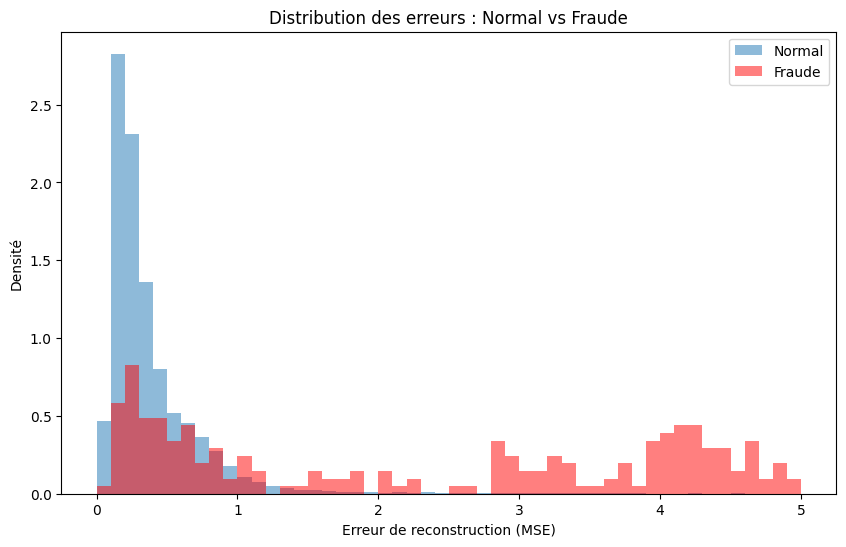

In [36]:
import matplotlib.pyplot as plt
import numpy as np


# Load model and move to device
name = str(input("Model Name ? "))
model = torch.load(os.path.join(
    model_path, f"model_{name}.pth"), map_location=device, weights_only=False)
model.to(device)

model.eval()

reconstruction_errors = []
true_labels = []

# Compute per-sample MSE reconstruction error
with torch.no_grad():
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)

        loss_per_sample = nn.MSELoss(reduction='none')(output, x).mean(dim=1)

        reconstruction_errors.extend(loss_per_sample.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
true_labels = np.array(true_labels)

# Plot distributions of reconstruction error for normal vs fraud
errors_normal = reconstruction_errors[true_labels == 0]
errors_fraud = reconstruction_errors[true_labels == 1]

plt.figure(figsize=(10, 6))
plt.hist(errors_normal, bins=50, alpha=0.5,
         label='Normal', density=True, range=(0, 5))
plt.hist(errors_fraud, bins=50, alpha=0.5, label='Fraude',
         color='red', density=True, range=(0, 5))
plt.xlabel('Erreur de reconstruction (MSE)')
plt.ylabel('Densité')
plt.legend()
plt.title('Distribution des erreurs : Normal vs Fraude')
plt.show()

## Threshold selection & metrics
Compute the precision-recall curve, derive F1 scores for thresholds, choose the threshold that maximizes F1, then show the confusion matrix and classification report at that threshold.

Meilleur seuil trouvé : 3.9315
Meilleur F1-Score : 0.6434


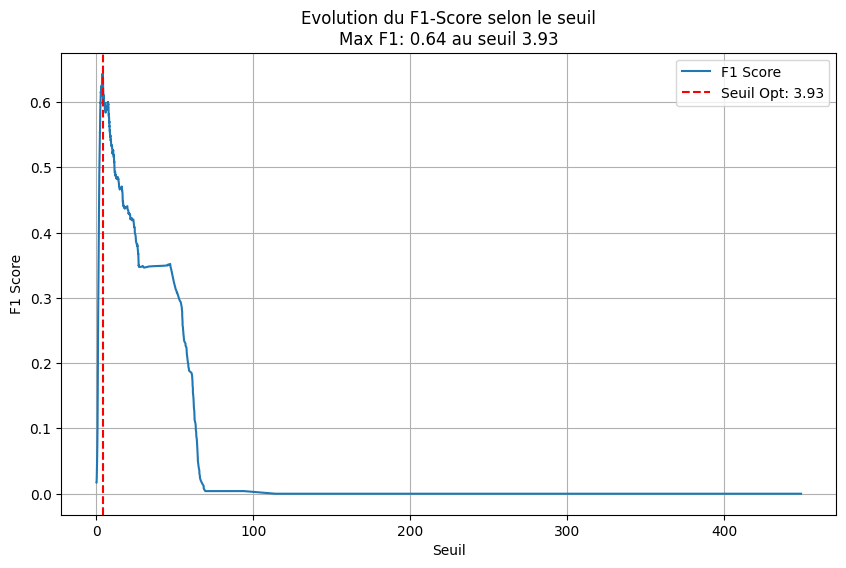


--- Résultats ---
[[56223   246]
 [  143   349]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56469
      Fraude       0.59      0.71      0.64       492

    accuracy                           0.99     56961
   macro avg       0.79      0.85      0.82     56961
weighted avg       0.99      0.99      0.99     56961



In [37]:
# Compute precision-recall curve and pick best threshold using F1 score
precisions, recalls, thresholds = precision_recall_curve(true_labels, reconstruction_errors)

# Compute F1 for each threshold
numerator = 2 * precisions * recalls
denominator = precisions + recalls

f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

best_idx = np.argmax(f1_scores)

# Make sure best_idx maps to a valid threshold index
if best_idx >= len(thresholds):
    best_idx = len(thresholds) - 1

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Meilleur seuil trouvé : {best_threshold:.4f}")
print(f"Meilleur F1-Score : {best_f1:.4f}")

# Plot F1 over thresholds (ignore last element alignment)
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil Opt: {best_threshold:.2f}')
plt.title(f"Evolution du F1-Score selon le seuil\nMax F1: {best_f1:.2f} au seuil {best_threshold:.2f}")
plt.xlabel('Seuil')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Résultats ---")
# Make predictions using best threshold and show confusion matrix / report
y_pred_opt = [1 if e > best_threshold else 0 for e in reconstruction_errors]
print(confusion_matrix(true_labels, y_pred_opt))
print(classification_report(true_labels, y_pred_opt, target_names=['Normal', 'Fraude']))